Copyright (c) Adnan-CAS  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at 

http://www.apache.org/licenses/LICENSE-2.0  
    

Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.


# 10 simple steps for 3D Multi-organ Segmentation

# UNETR: Transformers for 3D Medical Image Segmentation

3D Multi-organ Segmentation with UNETR  (BTCV Dataset)


This tutorial is highly adopted from the baseline work [1] which demonstrates how to construct a training workflow of UNETR [2] on multi-organ segmentation task using the BTCV challenge dataset.
![image](https://lh3.googleusercontent.com/pw/AM-JKLU2eTW17rYtCmiZP3WWC-U1HCPOHwLe6pxOfJXwv2W-00aHfsNy7jeGV1dwUq0PXFOtkqasQ2Vyhcu6xkKsPzy3wx7O6yGOTJ7ZzA01S6LSh8szbjNLfpbuGgMe6ClpiS61KGvqu71xXFnNcyvJNFjN=w1448-h496-no?authuser=0)

The main features are:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNETR model, DiceCE loss function, Mean Dice metric for multi-organ segmentation task.

# BTCV Dataset Intro
The dataset can be dowloaded from https://www.synapse.org/#!Synapse:syn3193805/wiki/217752.  

50 abdomen CT scans were chosen at random under the supervision of the Institutional Review Board (IRB). These scans were obtained during the portal venous contrast phase and were selected from a combination of an ongoing trial for colorectal cancer chemotherapy and a retrospective study for ventral hernias. The volume sizes ranged from 512 x 512 x 85 to 512 x 512 x 198, while the field of views varied from approximately 280 x 280 x 280 mm3 to 500 x 500 x 650 mm3. In-plane resolution varied between 0.54 x 0.54 mm2 and 0.98 x 0.98 mm2, and the slice thickness ranged from 2.5 mm to 5.0 mm.

Target: 13 abdominal organs including 1. Spleen 2. Right Kidney 3. Left Kidney 4.Gallbladder 5.Esophagus 6. Liver 7. Stomach 8.Aorta 9. IVC 10. Portal and Splenic Veins 11. Pancreas 12 Right adrenal gland 13 Left adrenal gland.

Modality: CT
Size: 30 3D volumes (24 Training + 6 Testing)  
Challenge: BTCV MICCAI Challenge

The following figure shows image patches with the organ sub-regions that are annotated in the CT (top left) and the final labels for the whole dataset (right)[3][4].
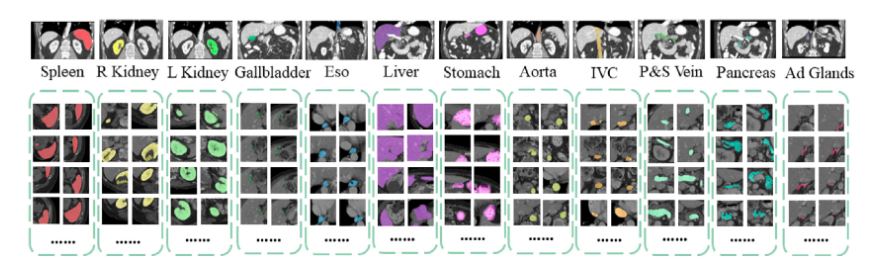

The image patches show anatomies of a subject, including: 
1. large organs: spleen, liver, stomach. 
2. Smaller organs: gallbladder, esophagus, kidneys, pancreas. 
3. Vascular tissues: aorta, IVC, P&S Veins. 
4. Glands: left and right adrenal gland

# References:

[1]: 3D Multi-organ Segmentation with UNETR
(https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb)

[2]: Hatamizadeh, A., Tang, Y., Nath, V., Yang, D., Myronenko, A., Landman, B., Roth, H.R. and Xu, D., 2022. Unetr: Transformers for 3d medical image segmentation. In Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision (pp. 574-584).

[3]: [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

[4]: [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)

### Step 1: Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

### Step 2: Setup imports

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss, SSIMLoss,DiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

C:\ProgramData\anaconda3\envs\Exp4\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.dev2347
Numpy version: 1.26.1
Pytorch version: 2.1.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 1aa9c70896639db26e06b3de94065113a54c13f5
MONAI __file__: C:\ProgramData\anaconda3\envs\Exp4\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.11.3
Pillow version: 10.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.0+cu121
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.1.2
einops version: 0.7.0
transformers version: 4.36.0.dev0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERS

### Step 3: Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\ADMINI~1\AppData\Local\Temp\tmpvwfjlydp


### Step 4: Setup transforms for training and validation

In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

C:\ProgramData\anaconda3\envs\Exp4\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


 ### Step 5: Download dataset and format in the folder.
 
    1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480\n
    2. Put images in the ./data/imagesTr
    3. Put labels in the ./data/labelsTr
    4. make JSON file accordingly: ./data/dataset_0.json
    Example of JSON file:
     {
    "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "spleen",
        "2": "rkid",
        "3": "lkid",
        "4": "gall",
        "5": "eso",
        "6": "liver",
        "7": "sto",
        "8": "aorta",
        "9": "IVC",
        "10": "veins",
        "11": "pancreas",
        "12": "rad",
        "13": "lad"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [
        "imagesTs/img0061.nii.gz",
        "imagesTs/img0062.nii.gz",
        "imagesTs/img0063.nii.gz",
        "imagesTs/img0064.nii.gz",
        "imagesTs/img0065.nii.gz",
        "imagesTs/img0066.nii.gz",
        "imagesTs/img0067.nii.gz",
        "imagesTs/img0068.nii.gz",
        "imagesTs/img0069.nii.gz",
        "imagesTs/img0070.nii.gz",
        "imagesTs/img0071.nii.gz",
        "imagesTs/img0072.nii.gz",
        "imagesTs/img0073.nii.gz",
        "imagesTs/img0074.nii.gz",
        "imagesTs/img0075.nii.gz",
        "imagesTs/img0076.nii.gz",
        "imagesTs/img0077.nii.gz",
        "imagesTs/img0078.nii.gz",
        "imagesTs/img0079.nii.gz",
        "imagesTs/img0080.nii.gz"
    ],
    "training": [
        {
            "image": "imagesTr/img0001.nii.gz",
            "label": "labelsTr/label0001.nii.gz"
        },
        {
            "image": "imagesTr/img0002.nii.gz",
            "label": "labelsTr/label0002.nii.gz"
        },
        {
            "image": "imagesTr/img0003.nii.gz",
            "label": "labelsTr/label0003.nii.gz"
        },
        {
            "image": "imagesTr/img0004.nii.gz",
            "label": "labelsTr/label0004.nii.gz"
        },
        {
            "image": "imagesTr/img0005.nii.gz",
            "label": "labelsTr/label0005.nii.gz"
        },
        {
            "image": "imagesTr/img0006.nii.gz",
            "label": "labelsTr/label0006.nii.gz"
        },
        {
            "image": "imagesTr/img0007.nii.gz",
            "label": "labelsTr/label0007.nii.gz"
        },
        {
            "image": "imagesTr/img0008.nii.gz",
            "label": "labelsTr/label0008.nii.gz"
        },
        {
            "image": "imagesTr/img0009.nii.gz",
            "label": "labelsTr/label0009.nii.gz"
        },
        {
            "image": "imagesTr/img0010.nii.gz",
            "label": "labelsTr/label0010.nii.gz"
        },
        {
            "image": "imagesTr/img0021.nii.gz",
            "label": "labelsTr/label0021.nii.gz"
        },
        {
            "image": "imagesTr/img0022.nii.gz",
            "label": "labelsTr/label0022.nii.gz"
        },
        {
            "image": "imagesTr/img0023.nii.gz",
            "label": "labelsTr/label0023.nii.gz"
        },
        {
            "image": "imagesTr/img0024.nii.gz",
            "label": "labelsTr/label0024.nii.gz"
        },
        {
            "image": "imagesTr/img0025.nii.gz",
            "label": "labelsTr/label0025.nii.gz"
        },
        {
            "image": "imagesTr/img0026.nii.gz",
            "label": "labelsTr/label0026.nii.gz"
        },
        {
            "image": "imagesTr/img0027.nii.gz",
            "label": "labelsTr/label0027.nii.gz"
        },
        {
            "image": "imagesTr/img0028.nii.gz",
            "label": "labelsTr/label0028.nii.gz"
        },
        {
            "image": "imagesTr/img0029.nii.gz",
            "label": "labelsTr/label0029.nii.gz"
        },
        {
            "image": "imagesTr/img0030.nii.gz",
            "label": "labelsTr/label0030.nii.gz"
        },
        {
            "image": "imagesTr/img0031.nii.gz",
            "label": "labelsTr/label0031.nii.gz"
        },
        {
            "image": "imagesTr/img0032.nii.gz",
            "label": "labelsTr/label0032.nii.gz"
        },
        {
            "image": "imagesTr/img0033.nii.gz",
            "label": "labelsTr/label0033.nii.gz"
        },
        {
            "image": "imagesTr/img0034.nii.gz",
            "label": "labelsTr/label0034.nii.gz"
        }
    ],
    "validation": [
        {
            "image": "imagesTr/img0035.nii.gz",
            "label": "labelsTr/label0035.nii.gz"
        },
        {
            "image": "imagesTr/img0036.nii.gz",
            "label": "labelsTr/label0036.nii.gz"
        },
        {
            "image": "imagesTr/img0037.nii.gz",
            "label": "labelsTr/label0037.nii.gz"
        },
        {
            "image": "imagesTr/img0038.nii.gz",
            "label": "labelsTr/label0038.nii.gz"
        },
        {
            "image": "imagesTr/img0039.nii.gz",
            "label": "labelsTr/label0039.nii.gz"
        },
        {
            "image": "imagesTr/img0040.nii.gz",
            "label": "labelsTr/label0040.nii.gz"
        }
    ]
}
    

### Step 6: Set the path for data DIR and json file

In [5]:
data_dir = "C:/ProgramData/anaconda3/envs/Exp4/data/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


In [ ]:
import os
print(os.getcwd())

### Additional Step to Check data shape and visualize

image shape: torch.Size([1, 255, 223, 276]), label shape: torch.Size([1, 255, 223, 276])


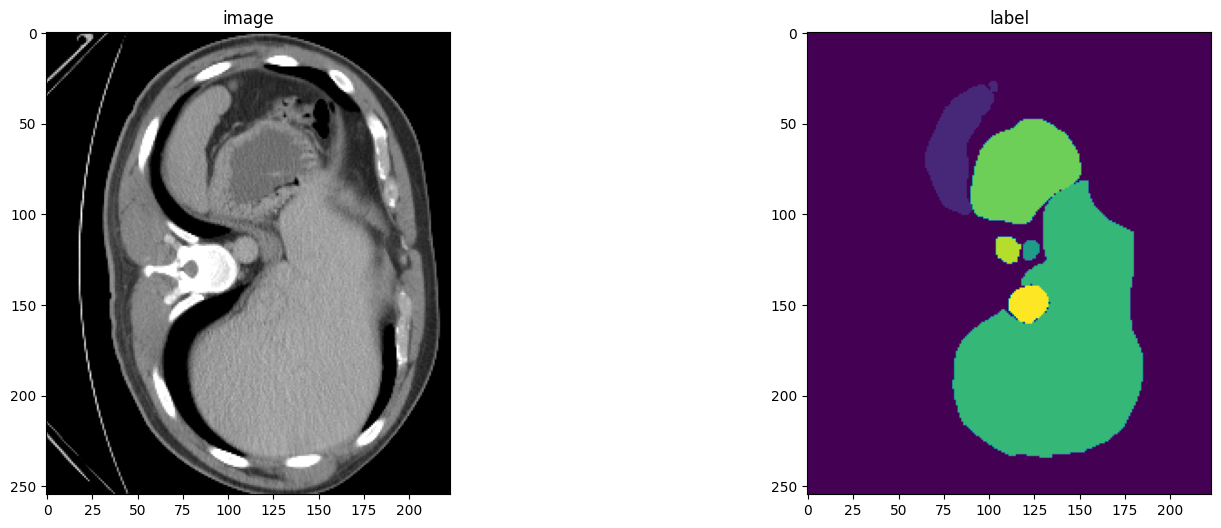

In [6]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [ ]:
print(img_shape)

### Step 7: Create Model, Loss, Optimizer


In [7]:
import torch.nn as nn
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

C:\ProgramData\anaconda3\envs\Exp4\Lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


### Step 8: Execute a typical PyTorch training process

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        # Ensure the ground truth has 14 channels
        y_onehot = torch.nn.functional.one_hot(y.long(), num_classes=14).float()

        # Transpose and view to reshape the tensor
        y_onehot = torch.transpose(y_onehot, 1, 4).contiguous().view(-1, 14, 96, 96, 96).float()

        logit_map = model(x)
        loss = loss_function(logit_map, y_onehot)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 20000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

In [ ]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

### Step 9: Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Step 10: Check best model output with the input image and label

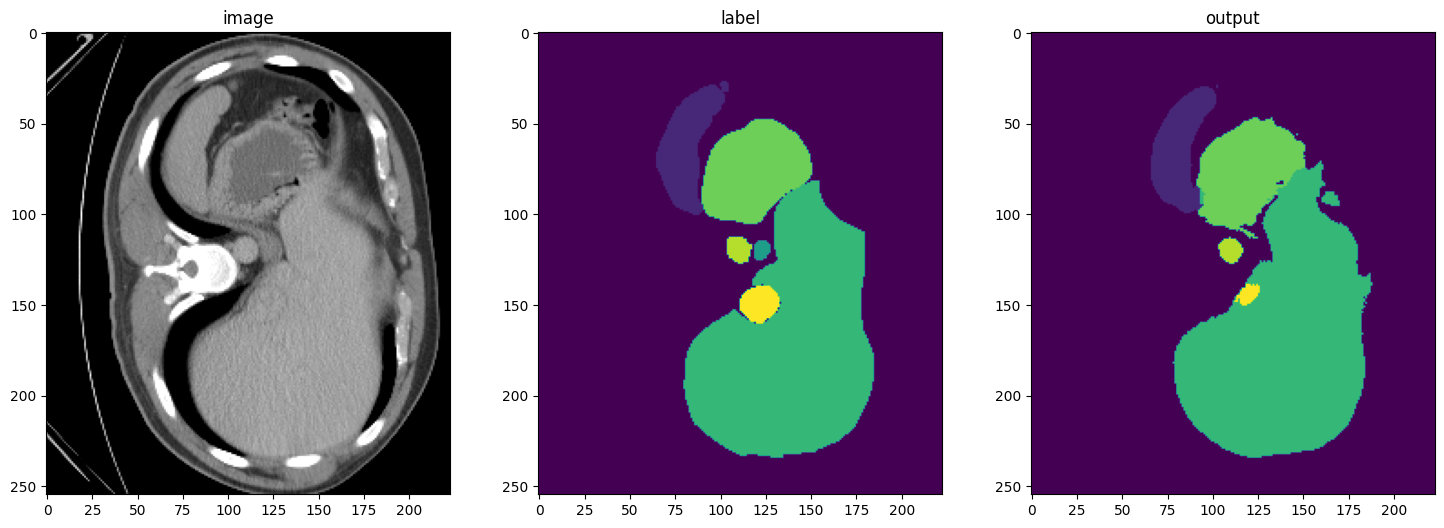

In [11]:
case_num = 2
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model-10K.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)